In [167]:
import json
import argparse
import code
from pprint import pprint
from termcolor import colored
import re
import random
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any
from collections import defaultdict

import ast
import astpretty
from pprintast import pprintast

import token
from tokenize import tokenize
import io
import builtins

%matplotlib inline

In [168]:
train_file = '../raw-datasets/conala-corpus/conala-train.json'
test_file = '../raw-datasets/conala-corpus/conala-test.json'

In [169]:
keywords = {
    # python libs
    "os"         : ['os.', 'from os import'],
    "(sh|ps)util": ['shutil.', 'psutil.', 'from shutil import', 'from psutil import'],
    "sys"        : ['sys.', 'from sys import'],
    "struct"     : ['struct.', 'from struct import'],
    "subprocess" : ['subprocess.', 'from subprocess import'],
    "date-time"  : ['datetime.', 'calendar.', 'from datetime import', 'from calendar import'],
    "time"       : ['time.', 'from time import'],
    "urllib"     : ['urllib.', 'from urllib import'],
    "regex"      : ['re.', 'from re import'],
    "itertools"  : ['itertools.', 'from itertools import'],
    "random"     : ['random.', 'from random import'],
    "requests"   : ['request.', 'requests.'],
    "io"         : ['open(', '.send('],
    "str-join"   : [".join("],

    # 3rd party libs
    "django"     : ['django'],
    "scipy"      : ['scipy.', 'from scipy import'],
    "numpy"      : ['np.', 'numpy.', 'from numpy import'],
    "pickle"     : ['pickle.', 'from pickle import'],
    "pandas"     : ['pd.', 'df[', 'df.', 'from pandas import', 'dataframe', 'pandas'],
    "matplotlib" : ['plt.' 'fig.', 'ax.', 'import matplotlib', 'from matplotlib import'],
    "networkx"   : ['nx.', 'from networkx import'],
    "gui"        : ['gi.', 'wx.', 'tk.', 'dogtail'],
    "flask"      : ['flask.', 'from flask import'],

    # calls
    "functional" : ['map(', 'filter(', 'reduce(', 'zip(', 'sum(', 'sorted('],
    "print"      : ['print('],
    
    "lambda"     : ['lambda', 'anonymous'],

    # list comprehension
    "list-comp"  : [lambda x: x[0] == '[' and x[-1] == ']'],
    
    # generator
    "generator"  : [lambda x: x[0] == '(' and x[-1] == ')'],
}

def get_unique(xs):
    u, c = np.unique(xs, return_counts=True)
    _c = np.argsort(-c)

    return u[_c], c[_c]

def query_by_key(data: Dict[str, Any], key):
    return [data[i][key] for i in range(len(data))]

def get_by_qid(data: Dict[str, Any], qid: int):
    return list(filter(lambda ex: ex["question_id"] == qid, data))

def get_by_keywords(data: Dict[str, Any]):
    xs = defaultdict(lambda: [])
 
    for q in data:
        found = False
        
        for ks in keywords:
            for k in keywords[ks]:
            
                i = q["intent"].lower()
                ri = q["rewritten_intent"].lower() if q["rewritten_intent"] else None
                s = q["snippet"].lower()
                
                if isinstance(k, str):
                    if (k in i) or (ri and k in ri) or (k in s):
                        xs[ks].append(q)
                        found = True
                
                # lambda predicate
                else:
                    if k(s):
                        xs[ks].append(q)
                        found = True
            
        # other keywords
        if not found:
            xs['other'].append(q)

    return xs

In [170]:
train_data = json.load(open(train_file, "rt"))
test_data = json.load(open(test_file, "rt"))

train_uids, train_cuids = get_unique(query_by_key(train_data, "question_id"))
test_uids, test_cuids = get_unique(query_by_key(test_data, "question_id"))

train_none_rewritten = [x for x in train_data if x['rewritten_intent'] is None]
test_none_rewritten = [x for x in test_data if x['rewritten_intent'] is None]

print(f"[train] {train_uids.size} unique ids")
print(f"[train] null-rewritten {round(100.0*len(train_none_rewritten)/len(train_data),3)}%")
print(f"[test] {test_uids.size} unique ids")
print(f"[test] null-rewritten {round(100.0*len(test_none_rewritten)/len(test_data),3)}%")

[train] 1710 unique ids
[train] null-rewritten 3.321%
[test] 364 unique ids
[test] null-rewritten 4.6%


train-other: 34%
test-other: 33%


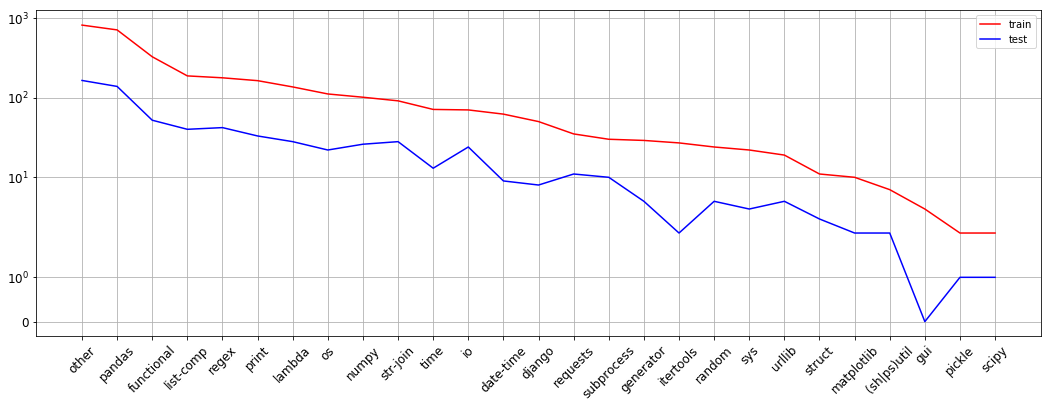

In [171]:
train_xs = get_by_keywords(train_data)
test_xs = get_by_keywords(test_data)

# print("[train]")
# for l, qs in sorted(train_xs.items(), key=lambda k : len(k[1]), reverse=True):
#     print(f"{l} -> {len(qs)}({round(100.0 * len(qs)/len(train_data), 3)}%)")
# print()

# print("[test]")
# for l, qs in sorted(test_xs.items(), key=lambda k : len(k[1]), reverse=True):
#     print(f"{l} -> {len(qs)}({round(100.0 * len(qs)/len(test_data), 3)}%)")

print(f"train-other: {round(100.0 * len(train_xs['other']) / len(train_data))}%")
print(f"test-other: {round(100.0 * len(test_xs['other']) / len(test_data))}%")

s = sorted(train_xs.items(), key=lambda k : len(k[1]), reverse=True)
labels = [x[0] for x in s]

plt.figure(figsize=(int(0.67 * len(labels)), 6))

plt.xticks(range(len(s)), labels, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('symlog')

plt.plot(range(len(s)), [len(x[1]) for x in s], 'r-', label='train')
plt.plot(range(len(s)), [len(test_xs[k]) for k in labels], 'b-', label='test')

plt.legend()
plt.grid()
plt.show()

## Sketch (similar to Coarse-to-Fine)

In [153]:
class SketchVocab:
    NAME_ID       = "<name>"
    LITERAL_ID    = "<literal>"
    RESERVED_ID   = "<reserved>"
    ACCESSOR_ID   = "<accessor>"
    ASSIGN_ID     = "<assign>"
    ARITHMETIC_ID = "<arithmetic>"
    OP_ID         = "<op>"

    
class Sketch:
    
    def __init__(self, code_snippet: str, with_ast=False):
        self.code_snippet = code_snippet
        
        self.names = defaultdict(lambda: [])
        self.keywords = defaultdict(lambda: [])
        self.operators = defaultdict(lambda: [])
        self.literals = defaultdict(lambda: [])
        
        self.ordered = []
        
        # namedtuple: type string start end line
        self.tok_list = list(tokenize(io.BytesIO(self.code_snippet.encode('utf-8')).readline))
        
        # AST
        self.tree = ast.parse(code_snippet) if with_ast else None
        
        
    def generate(self):
        """
        TODO:
        - separate support for slices?
        - use AST to enrich names? (eg. vars / function calls)
        """
        
        for tok in self.tok_list:
            tok_type = token.tok_name[tok.type]
            
            if tok_type == 'NAME':
                if self.is_reserved_keyword(tok.string):
                    self.keywords[tok.string].append(tok.start[1])
                    # self.ordered.append(Sketch.RESERVED_ID)
                    self.ordered.append(tok.string)
                else:
                    self.names[tok.string].append(tok.start[1])
                    self.ordered.append(SketchVocab.NAME_ID)
            
            elif tok_type in ['STRING', 'NUMBER']:
                self.literals[tok.string].append(tok.start[1])
                self.ordered.append(SketchVocab.LITERAL_ID)
                
            elif tok_type == "OP":
                self.operators[tok.string].append(tok.start[1])
                if tok.string in ["(", ")", "[", "]", "{", "}", ",", ":"]:
                    self.ordered.append(tok.string)
                elif tok.string == ".":
                    self.ordered.append(SketchVocab.ACCESSOR_ID)
                elif tok.string == "=":
                    self.ordered.append(SketchVocab.ASSIGN_ID)
                elif tok.string in ["+", "-", "*", "/"]:
                    self.ordered.append(SketchVocab.ARITHMETIC_ID)
                else:
                    self.ordered.append(SketchVocab.OP_ID)
                
            else:
                assert tok_type in ['ENCODING', 'NEWLINE', 'ENDMARKER']
        
        return self
    
    
    def details(self):
        return f"names    : {str(list(self.names.items()))}\n" + \
            f"keywords : {str(list(self.keywords.items()))}\n" + \
            f"literals : {str(list(self.literals.items()))}\n" + \
            f"operators: {str(list(self.operators.items()))}"
    
    def __str__(self):
        return " ".join(self.ordered)
    
    def __repr__(self):
        return str(self)

    
    @staticmethod
    def is_reserved_keyword(name):
        RESERVED_KEYWORDS = set(dir(builtins) + [
            "and", "assert", "break", "class", "continue", "def", "del", "elif", 
            "else", "except", "exec", "finally", "for", "from", "global", "if", 
            "import", "in", "is", "lambda", "not", "or", "pass", "print", "raise", 
            "return", "try", "while", "yield", "None", "self"
        ])

        return name in RESERVED_KEYWORDS 

### Sketch example

```
  x        is a      lambda function   that performs        incrementing
<name>   <assign>    lambda <name>        <op>         <name><arithmetic><literal>
  x         =        lambda   a            :                   a + 1
```

How about:

- Assign to x a lambda function that performs incrementing
- Construct an anonymous function for incrementing and assign it to a variable

In [165]:
idx = random.randint(0, len(train_data))
code_snippet = train_data[idx]['snippet']
# code_snippet = "[x for x in range(10, 20)]"

print(train_data[idx]['rewritten_intent'], "\n")
print(code_snippet, "\n")

sketch = Sketch(code_snippet, with_ast=False).generate()

# print(sketch.details())
print(sketch)

get logical xor of `a` and `b` 

(bool(a) ^ bool(b)) 

( bool ( <name> ) <op> bool ( <name> ) )


### AST

In [155]:
class MyTransformer(ast.NodeTransformer):
    def visit_Call(self, node: ast.Name):
#         print(node)
        return ast.copy_location(node, node)

    
tree = ast.parse(code_snippet)
# tree = MyTransformer().visit(tree)

astpretty.pprint(tree.body[0], indent=' ' * 4)
# pprintast(code_snippet)

# exec(compile(tree, filename="<ast>", mode="exec"))

Expr(
    lineno=1,
    col_offset=0,
    value=Call(
        lineno=1,
        col_offset=0,
        func=Name(lineno=1, col_offset=0, id='list', ctx=Load()),
        args=[
            GeneratorExp(
                lineno=1,
                col_offset=5,
                elt=BinOp(
                    lineno=1,
                    col_offset=5,
                    left=Name(lineno=1, col_offset=5, id='x', ctx=Load()),
                    op=Mult(),
                    right=Name(lineno=1, col_offset=9, id='y', ctx=Load()),
                ),
                generators=[
                    comprehension(
                        target=Tuple(
                            lineno=1,
                            col_offset=15,
                            elts=[
                                Name(lineno=1, col_offset=15, id='x', ctx=Store()),
                                Name(lineno=1, col_offset=18, id='y', ctx=Store()),
                            ],
                            ctx=St

## TranX intent preprocessing

In [156]:
QUOTED_TOKEN_RE = re.compile(r"(?P<quote>''|[`'\"])(?P<string>.*?)(?P=quote)")


def infer_slot_type(quote, value):
    if quote == '`' and value.isidentifier():
        return 'var'
    return 'str'


def canonicalize_intent(intent):
    # handle the following special case: quote is `''`
    marked_token_matches = QUOTED_TOKEN_RE.findall(intent)

    slot_map = dict()
    var_id = 0
    str_id = 0
    for match in marked_token_matches:
        quote = match[0]
        value = match[1]
        quoted_value = quote + value + quote

        # try:
        #     # if it's a number, then keep it and leave it to the copy mechanism
        #     float(value)
        #     intent = intent.replace(quoted_value, value)
        #     continue
        # except:
        #     pass

        slot_type = infer_slot_type(quote, value)

        if slot_type == 'var':
            slot_name = 'var_%d' % var_id
            var_id += 1
            slot_type = 'var'
        else:
            slot_name = 'str_%d' % str_id
            str_id += 1
            slot_type = 'str'

        # slot_id = len(slot_map)
        # slot_name = 'slot_%d' % slot_id
        # # make sure slot_name is also unicode
        # slot_name = unicode(slot_name)

        intent = intent.replace(quoted_value, slot_name)
        slot_map[slot_name] = {'value': value.strip().encode().decode('unicode_escape', 'ignore'),
                               'quote': quote,
                               'type' : slot_type}

    return intent, slot_map

In [162]:
x = random.sample(train_data, 1)[0]

i = x['rewritten_intent'] if x['rewritten_intent'] is not None else x['intent']
print(i)
print("---")

i, s = canonicalize_intent("substitute 1 for `x`")

print(i)
print("---")

pprint(s)

check if string `my_string` is empty
---
substitute 1 for var_0
---
{'var_0': {'quote': '`', 'type': 'var', 'value': 'x'}}
